# Reaction-Type Visualization

This section systematically evaluates the model's ability to distinguish between different chemical reaction types using both supervised pre-training tasks and  clustering strategies. The first three subsections reproduce the discriminative capabilities acquired during pre-training, while the fourth subsection introduces clustering analysis as an exploratory extension to further investigate the latent organization of the reaction embedding space.

## 1. data process
- Concatenate reactants and products to get the SMILES of the reaction

In [1]:
import warnings

import pandas as pd

from rxngraphormer.rxn_emb import RXNEMB

warnings.filterwarnings("ignore")

pretrain_model_path = "../model_path/pretrained_classification_model"
rct_path = "../dataset/50k_with_rxn_type/50k_rxn_type_rct_0.csv"
pdt_path = "../dataset/50k_with_rxn_type/50k_rxn_type_pdt_0.csv"
rxn_path = "../dataset/50k_with_rxn_type/50k_rxn_type.csv"
rxn_emb_pth = "./2_ReactionType_Res/rxn_emb_pretrained.pt"
rxn_heatmap_pth = "./2_ReactionType_Res/mat_diag_heatmap.png"
knn_heatmap_pth = "./2_ReactionType_Res/knn_heatmap.png"

rct_df = pd.read_csv(rct_path)
pdt_df = pd.read_csv(pdt_path)

if len(rct_df) != len(pdt_df):
    raise ValueError("Error")

combined_col = rct_df.iloc[:, 0] + ">>" + pdt_df.iloc[:, 0]

result_df = pd.DataFrame({
    "combined_rct_pdt": combined_col,
    "label": pdt_df.iloc[:, 1]
})

result_df.to_csv(rxn_path, index=False)
print(result_df.head())

                                    combined_rct_pdt  label
0  CCOC(C)=O.Cc1cc([N+](=O)[O-])ccc1NC(=O)c1ccccc...     36
1  COc1ccc(-c2coc3ccc(-c4nnc(S)o4)cc23)cc1.COc1cc...     13
2  CCS(=O)(=O)Cl.CN(C(=O)N(C)[C@@H]1CN(C(=O)C2CCN...     17
3  COc1ccc(OC)c(N)c1.Cc1cc(Cl)nc(-c2ccccn2)n1>>CO...      4
4  CC(C)=O.CC1CCC(C(C)C)C(OCCl)C1.CCN(CC)CC.CCOC(...     12


## 2. Save embeddings

In [2]:
import torch

rxnemb_calc_pretrained = RXNEMB(pretrained_model_path=pretrain_model_path, model_type="classifier")
rxn_emb_pretrained = rxnemb_calc_pretrained.gen_rxn_emb(result_df.iloc[:, 0])
# torch.save(rxn_emb_pretrained, rxn_emb_pth)

Processing...
  0%|          | 35/49999 [00:00<02:24, 346.68it/s]

[INFO] There are 1 data files in total
[INFO] All data 1 files will be used
[INFO] ./rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 49999/49999 [02:35<00:00, 321.71it/s]


[INFO] 49999 data index 0 is saving...


Done!
Processing...
  0%|          | 61/49999 [00:00<01:22, 606.78it/s]

[INFO] There are 1 data files in total
[INFO] All data 1 files will be used
[INFO] ./rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 49999/49999 [01:25<00:00, 585.51it/s]


[INFO] 49999 data index 0 is saving...


Done!
  0%|          | 0/391 [00:00<?, ?it/s]

[INFO] Generating reaction embedding...


100%|██████████| 391/391 [00:47<00:00,  8.30it/s]


## 3.  Heatmap of USPTO-50K
### 3.1 Distance calculation

In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# rxn_emb_pretrained = torch.load(rxn_emb_pth)
labels = pd.read_csv(rxn_path).iloc[:, 1]
unique_labels = np.unique(labels)
label_emb = {}
for label in unique_labels:
    mask = (labels == label)
    label_emb[label] = rxn_emb_pretrained[mask]

distance_results = []
for i in range(len(unique_labels)):
    label1 = unique_labels[i]
    emb1 = label_emb[label1]

    for j in range(i + 1, len(unique_labels)):
        label2 = unique_labels[j]
        emb2 = label_emb[label2]

        dist_matrix = torch.cdist(emb1.unsqueeze(0), emb2.unsqueeze(0)).squeeze(0)
        avg_dist = dist_matrix.mean().item()

        distance_results.append({
            "label1": label1,
            "label2": label2,
            "avg_euclidean_distance": avg_dist
        })

sorted_labels = sorted(unique_labels)
n = len(sorted_labels)
distance_matrix = torch.zeros(n, n)

for result in distance_results:
    i = sorted_labels.index(result["label1"])
    j = sorted_labels.index(result["label2"])
    distance_matrix[i, j] = result["avg_euclidean_distance"]
    distance_matrix[j, i] = result["avg_euclidean_distance"]


def compute_intra_label_avg_distance(embeddings):
    n_samples = embeddings.shape[0]
    if n_samples < 2:
        return 0.0

    dist_matrix = torch.cdist(embeddings, embeddings)

    i_indices, j_indices = torch.triu_indices(n_samples, n_samples, offset=1)
    pairwise_dists = dist_matrix[i_indices, j_indices]
    return pairwise_dists.mean().item()


for idx, label in enumerate(sorted_labels):
    emb = label_emb[label]
    intra_avg_dist = compute_intra_label_avg_distance(emb)
    distance_matrix[idx, idx] = intra_avg_dist

distance_matrix_np = distance_matrix.numpy()

### 3.3 Plot

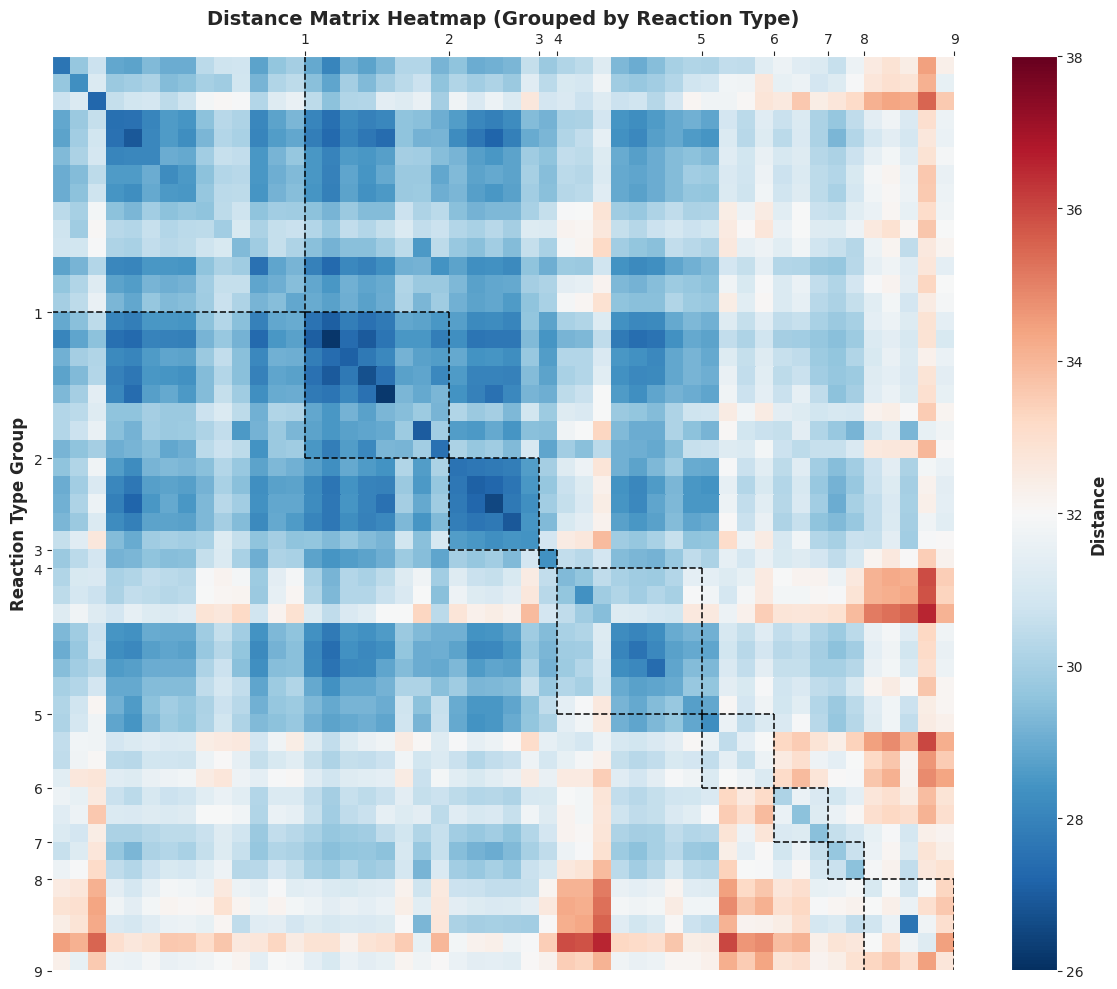

In [4]:
# Generate sorted labels (1-50)
sorted_labels = [f"{i + 1}" for i in range(50)]

# Manual grouping (non-equal length, total 50 labels)
groups = [
    sorted_labels[0:14],  # Group1: 14 labels (0-13)
    sorted_labels[14:22],  # Group2: 8 labels (14-21)
    sorted_labels[22:27],  # Group3: 5 labels (22-26)
    sorted_labels[27:28],  # Group4: 1 label (27)
    sorted_labels[28:36],  # Group5: 8 labels (28-35)
    sorted_labels[36:40],  # Group6: 4 labels (36-39)
    sorted_labels[40:43],  # Group7: 3 labels (40-42)
    sorted_labels[43:45],  # Group8: 2 labels (43-44)
    sorted_labels[45:50]  # Group9: 5 labels (45-49)
]
group_names = [f"{i + 1}" for i in range(9)]

# Calculate tick positions and labels
tick_positions = []
tick_labels = []
current_start = 0

for i, group in enumerate(groups):
    group_length = len(group)
    group_end = current_start + group_length
    tick_positions.append(group_end)
    tick_labels.append(group_names[i])
    current_start = group_end

# Plot heatmap
plt.figure(figsize=(12, 10))
im = plt.pcolormesh(
    distance_matrix_np,
    cmap="RdBu_r",
    vmin=26,
    vmax=38
)

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Distance', fontsize=12, fontweight='bold')

# Set labels and title
plt.xlabel('Reaction Type Group', fontsize=12, fontweight='bold')
plt.ylabel('Reaction Type Group', fontsize=12, fontweight='bold')
plt.title('Distance Matrix Heatmap (Grouped by Reaction Type)', fontsize=14, fontweight='bold')

# Configure ticks
plt.xticks(tick_positions, tick_labels, rotation=45, ha='right', fontsize=10, fontweight='bold')
plt.yticks(tick_positions, tick_labels, rotation=45, ha='right', fontsize=10, fontweight='bold')

# Adjust spines and axes
ax = plt.gca()
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.yaxis.tick_left()

# Add group boundaries
boundaries = [0] + tick_positions
for i in range(len(boundaries) - 1):
    x_left = boundaries[i]
    x_right = boundaries[i + 1]
    y_bottom = boundaries[i]
    y_top = boundaries[i + 1]

    # Draw grid lines
    ax.plot([x_left, x_left], [y_bottom, y_top], color='black', linestyle='--', alpha=0.9, linewidth=1.2)
    ax.plot([x_right, x_right], [y_bottom, y_top], color='black', linestyle='--', alpha=0.9, linewidth=1.2)
    ax.plot([x_left, x_right], [y_bottom, y_bottom], color='black', linestyle='--', alpha=0.9, linewidth=1.2)
    ax.plot([x_left, x_right], [y_top, y_top], color='black', linestyle='--', alpha=0.9, linewidth=1.2)

# Save and display
plt.tight_layout()
plt.savefig(rxn_heatmap_pth, dpi=300, bbox_inches='tight')
plt.show()

## 4. Reaction Type Clustering

This section extends the methodology of *"Distance analysis of reaction embeddings from USPTO-50k dataset"*  through a  clustering analysis of reaction embeddings. By leveraging the geometric properties of the reaction embedding space, we hypothesize that reactions with similar mechanistic pathways or functional group transformations will exhibit smaller pairwise distances, enabling their aggregation into chemically meaningful clusters.

Silhouette Score: 0.0403 (Range [-1, 1], higher is better)
Calinski-Harabasz Index: 1653.18 (Higher is better)
Davies-Bouldin Index: 3.4180 (Lower is better)


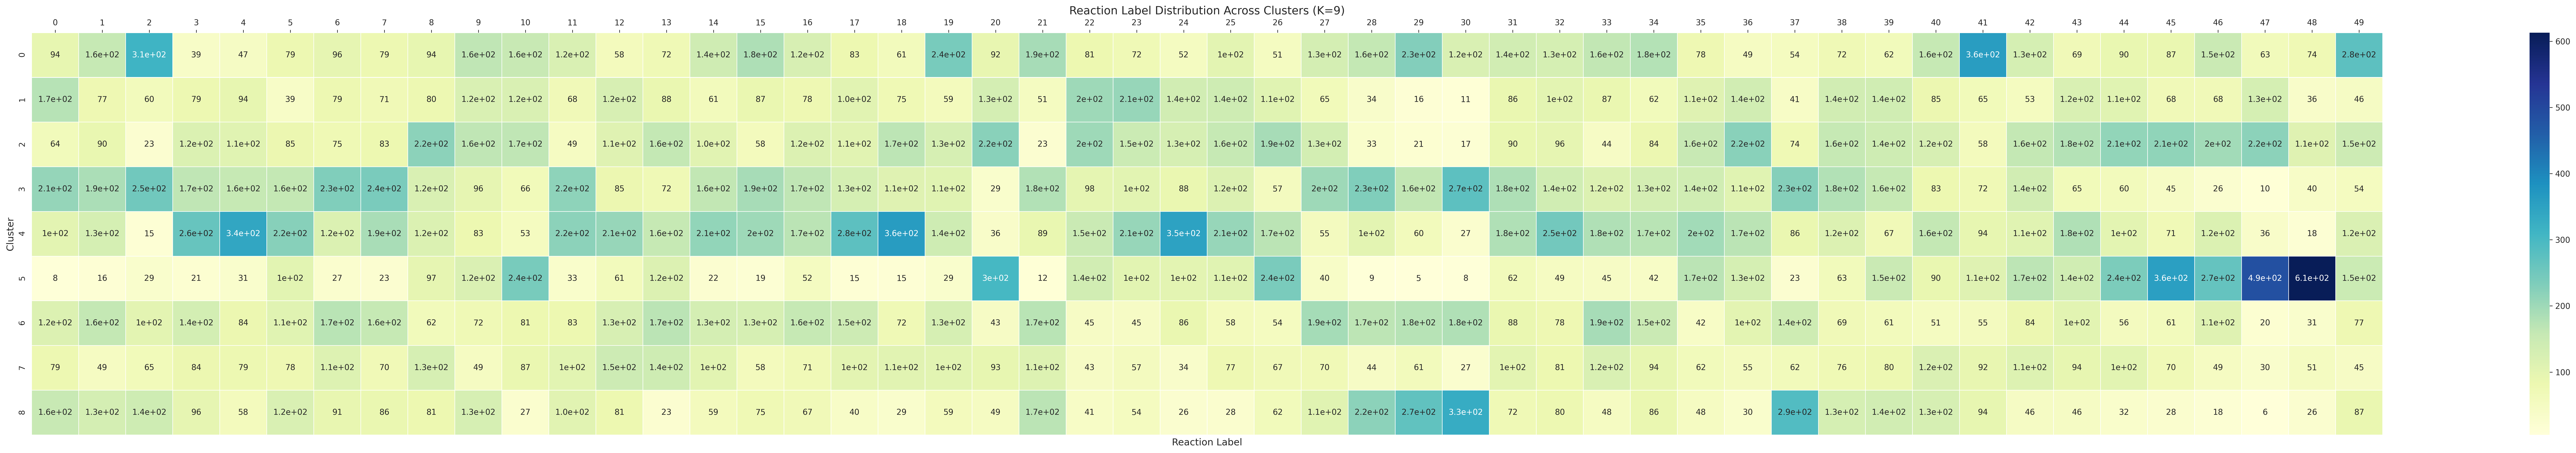

In [5]:
import torch
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Load pre-trained reaction embeddings and reaction labels
# rxn_emb_pretrained = torch.load(rxn_emb_pth)
labels = pd.read_csv(rxn_path).iloc[:, 1]
rxn_embeddings = rxn_emb_pretrained.numpy()
scaler = StandardScaler()
rxn_embeddings = scaler.fit_transform(rxn_embeddings)

# Perform KMeans clustering (k=9)
num_clusters = 9
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(rxn_embeddings)

# Evaluate clustering quality
silhouette = silhouette_score(rxn_embeddings, cluster_labels)
ch_score = calinski_harabasz_score(rxn_embeddings, cluster_labels)
db_score = davies_bouldin_score(rxn_embeddings, cluster_labels)

print(f"Silhouette Score: {silhouette:.4f} (Range [-1, 1], higher is better)")
print(f"Calinski-Harabasz Index: {ch_score:.2f} (Higher is better)")
print(f"Davies-Bouldin Index: {db_score:.4f} (Lower is better)")

# Create cluster-label mapping
cluster_label_df = pd.DataFrame({
    'cluster': cluster_labels,
    'reaction_label': labels
})
cluster_label_counts = pd.crosstab(
    index=cluster_label_df['cluster'],
    columns=cluster_label_df['reaction_label']
)

# Plot cluster distribution heatmap
plt.figure(figsize=(52, 8), dpi=300)
sns.heatmap(
    cluster_label_counts,
    cmap="YlGnBu",
    annot=True,
    linewidths=0.5
)
plt.title("Reaction Label Distribution Across Clusters (K=9)", fontsize=14)
plt.xlabel("Reaction Label", fontsize=12)
plt.ylabel("Cluster", fontsize=12)
ax = plt.gca()
ax.xaxis.tick_top()
plt.tight_layout()
plt.savefig(knn_heatmap_pth, dpi=300)
plt.show()

In [ ]:
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from hdbscan import HDBSCAN

# rxn_embeddings_scaled: your scaled embedding array
# labels: your ground truth labels for evaluation
# knn_heatmap_pth: path for saving figures

algorithms = {
    "KMeans": KMeans(n_clusters=9, random_state=42, n_init=10),
    "GaussianMixture": GaussianMixture(n_components=9, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=9, linkage='ward'),
    "HDBSCAN": HDBSCAN(min_cluster_size=9, min_samples=5)
}

results = {}

for name, algorithm in algorithms.items():
    print(f"\n=== Running {name} ===")
    try:
        if name == "HDBSCAN":
            cluster_labels = algorithm.fit_predict(rxn_embeddings)
        else:
            cluster_labels = algorithm.fit_predict(rxn_embeddings)

        # Count clusters and noise
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        noise_count = list(cluster_labels).count(-1) if -1 in cluster_labels else 0
        print(f"{name} found {n_clusters} clusters and {noise_count} noise points")

        # Mask to ignore noise for evaluation
        valid_mask = cluster_labels != -1 if name == "HDBSCAN" else np.ones(len(cluster_labels), dtype=bool)

        # Silhouette
        sil = silhouette_score(rxn_embeddings[valid_mask], cluster_labels[valid_mask]) \
            if len(np.unique(cluster_labels[valid_mask])) > 1 else float('nan')

        # ARI / NMI
        ari = adjusted_rand_score(labels[valid_mask], cluster_labels[valid_mask])
        nmi = normalized_mutual_info_score(labels[valid_mask], cluster_labels[valid_mask])

        print(f"Silhouette: {sil:.4f} | ARI: {ari:.4f} | NMI: {nmi:.4f}")

        results[name] = {
            "labels": cluster_labels,
            "silhouette": sil,
            "ari": ari,
            "nmi": nmi,
            "n_clusters": n_clusters,
            "noise_count": noise_count
        }

    except Exception as e:
        print(f"Error in {name}: {e}")



=== Running KMeans ===
KMeans found 9 clusters and 0 noise points
